In [55]:
import param
import numpy as np 
import pandas as pd
import panel as pn
import matplotlib.pyplot as plt
import chess
import chess.svg
from io import BytesIO
import cairosvg
import copy
from PIL import Image
from utils import get_nnue_eval_from_fen
from IPython.display import display, Markdown

In [70]:
fen = "7k/p2b2p1/1pr1p3/3pNp2/5P2/1P2P2P/1P5P/2R1R1K1 w - - 0 1"
board = chess.Board(fen)

letters = ['A','B','C','D','E','F','G','H']

def get_np_board(board):
    return np.array([x.split(' ') for x in str(board).split('\n')])


def where_to_array(where_result):
    return [np.array([where_result[0][i], where_result[1][i]]) for i in range(len(where_result[0]))]

def array_to_chess_pos(arr):
    return letters[arr[1]] +str(8-arr[0])  

def file_to_letter(file):
    return letters[file] 
    
def show_board(board):
    svg = chess.svg.board(board)
    img = cairosvg.svg2png(svg, scale=5.0)
    img = Image.open(BytesIO(img))

    plot = plt.figure(figsize=(7, 6))
    ax = plot.add_subplot(111)

    ax1_plot = ax.imshow(img)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.show()


def pos_idx_to_chess_pos(idx):
    rank = 7 - ((63-idx) // 8)
    file = (idx % 8) 
    return letters[file] +str(rank + 1)  

chess_symbol_to_name = {
    'r': 'rook',
    'q': 'queen',
    'n': 'knight',
    'p': 'pawn',
    'b': 'bishop',
    'k': 'king'
}






# Connected Rooks

In [57]:
def get_connected_rooks(board, color = 'white'):
    rook_symbol = 'R' if color == 'white' else 'r'
    np_board = get_np_board(board)
    rooks = np.where(np_board == rook_symbol)
    if len(rooks[0]) > 1: # more than one rook 
        if (rooks[0][0] == rooks[0][1]) | (rooks[1][0] == rooks[1][1]): # same file
            rook_line = np_board[min(rooks[0]):(max(rooks[0])+1), min(rooks[1]):(max(rooks[1])+1)]
            concept_activated = ((rook_line == '.') | (rook_line == rook_symbol)).all()
            if concept_activated:
                rook_positions = where_to_array(rooks)
                description = f'{color} has connected rooks on {array_to_chess_pos(rook_positions[0])} and {array_to_chess_pos(rook_positions[1])}'
                return {'concept_activated': concept_activated,
                        'description': description,
                        'color': color,
                        'concept_name': 'connected_rooks'}
    return {'concept_activated' : False,
            'color': color,
            'concept_name': 'connected_rooks'}



get_connected_rooks(board)

{'concept_activated': True,
 'description': 'white has connected rooks on C1 and E1',
 'color': 'white',
 'concept_name': 'connected_rooks'}

# Doubled Pawns

In [58]:
def get_doubled_pawns(board, color = 'white'):
    np_board = get_np_board(board)
    pawn_symbol = 'P' if color == 'white' else 'p'
    doubled_pawn_cols = np.where((np_board == pawn_symbol).sum(axis = 0) > 1)[0]
    if len(doubled_pawn_cols) > 0:
        description = f"{color} has doubled pawns on files {' and '.join([file_to_letter(x) for x in doubled_pawn_cols])}"
        return {'concept_activated': True,
                'description': description,
                'color': color,
                'concept_name': 'doubled_pawns'}
    return {'concept_activated' : False,
            'color': color,
            'concept_name': 'doubled_pawns'}

get_doubled_pawns(board, color = 'white')

{'concept_activated': True,
 'description': 'white has doubled pawns on files B and H',
 'color': 'white',
 'concept_name': 'doubled_pawns'}

# Isolated pawn

In [59]:

# Isolated Pawns
def get_isolated_pawns(board, color = 'white'):
    np_board = get_np_board(board)
    pawn_symbol = 'P' if color == 'white' else 'p'
    pos_any_pawn = ((np_board == pawn_symbol).sum(axis=0) > 0)
    isolated_pawns = np.where(pos_any_pawn & ~np.roll(pos_any_pawn, 1) & ~np.roll(pos_any_pawn, -1))[0]
    if len(isolated_pawns) > 0:
        description = f"{color} has isolated pawns on files {' and '.join([file_to_letter(x) for x in isolated_pawns])}"
        return {'concept_activated': True,
                'description': description,
                'color': color,
                'concept_name': 'isolated_pawns'}

    return {'concept_activated' : False,
            'color': color,
            'concept_name': 'isolated_pawns'}

get_isolated_pawns(board, color = 'white')

{'concept_activated': True,
 'description': 'white has isolated pawns on files B and H',
 'color': 'white',
 'concept_name': 'isolated_pawns'}

# Open Files

In [60]:

def has_control_of_open_file(board, color = 'white'):
    # Open Files
    np_board = get_np_board(board)
    rook_symbol = 'R' if color == 'white' else 'r'
    queen_symbol = 'Q' if color == 'white' else 'q'

    rook_symbol_opponent = 'r' if color == 'white' else 'R'
    queen_symbol_opponent = 'q' if color == 'white' else 'Q'

    no_pawns = (((np_board == 'p') | (np_board == 'P')).sum(axis=0) == 0)
    rook_or_queen_player = ((np_board == rook_symbol) | (np_board == queen_symbol)).any(axis=0)
    rook_or_queen_opponent = ((np_board == rook_symbol_opponent) | (np_board == queen_symbol_opponent)).any(axis=0)


    control_files = np.where(no_pawns & ~rook_or_queen_opponent & rook_or_queen_player)[0]
    if len(control_files) > 0:
        description = f"{color} has control of file(s) {' and '.join([file_to_letter(x) for x in control_files])}"
        return {'concept_activated': True,
                'description': description,
                'color': color,
                'concept_name': 'control_of_open_file'}
        

    return {'concept_activated' : False,
            'color': color,
            'concept_name': 'control_of_open_file'}


def has_contested_open_file(board):
    # Open Files
    color = 'white'
    np_board = get_np_board(board)
    rook_symbol = 'R' if color == 'white' else 'r'
    queen_symbol = 'Q' if color == 'white' else 'q'

    rook_symbol_opponent = 'r' if color == 'white' else 'R'
    queen_symbol_opponent = 'q' if color == 'white' else 'Q'

    no_pawns = (((np_board == 'p') | (np_board == 'P')).sum(axis=0) == 0)
    rook_or_queen_player = ((np_board == rook_symbol) | (np_board == queen_symbol)).any(axis=0)
    rook_or_queen_opponent = ((np_board == rook_symbol_opponent) | (np_board == queen_symbol_opponent)).any(axis=0)


    control_files = np.where(no_pawns & rook_or_queen_opponent & rook_or_queen_player)[0]
    if len(control_files) > 0:
        description = f"contested open file on file(s) {' and '.join([file_to_letter(x) for x in control_files])}"
        return {'concept_activated': True,
                'description': description,
                'color': 'both',
                'concept_name': 'contested_open_file'}
        

    return {'concept_activated' : False,
            'color': 'both',
            'concept_name': 'contested_open_file'}
    
display(has_control_of_open_file(board, color = 'white'))

display(has_contested_open_file(board))


{'concept_activated': False,
 'color': 'white',
 'concept_name': 'control_of_open_file'}

{'concept_activated': True,
 'description': 'contested open file on file(s) C',
 'color': 'both',
 'concept_name': 'contested_open_file'}

# Forking

In [61]:

def is_knight_forking(board, color='white'):
    
    high_value_pieces_white = ['K','Q','R', 'B']
    high_value_pieces_black = ['k','q','r', 'b']

    if color == 'white':
        high_value_pieces = high_value_pieces_black
    else:
        high_value_pieces = high_value_pieces_white



    piece_map = board.piece_map()
    knight_string = 'N' if color == 'white' else 'n'

    knight_positions = [d[0] for d in piece_map.items() if str(d[1]) == knight_string]
    

    if len(knight_positions) > 0:
        forks = []
        attacks = []
        for kn_pos in knight_positions:
            attacking = []
            if not board.is_pinned(board.turn, kn_pos):
                for square in board.attacks(kn_pos):
                    piece = board.piece_at(square)
                    if str(piece) in high_value_pieces:
                        attacking.append([piece, square])
                if len(attacking) > 1:
                    attacks.append((kn_pos, attacking))
                    
            if len(attacks) > 0:
                description = ' and '.join([f"{color} knight on {pos_idx_to_chess_pos(x[0])} is forking {chess_symbol_to_name[str(x[1][0][0])]} on {pos_idx_to_chess_pos(x[1][0][1])} and {chess_symbol_to_name[str(x[1][1][0])]} on {pos_idx_to_chess_pos(x[1][1][1])}" for x in attacks])
                return {'concept_activated': True,
                        'description': description,
                        'color': color,
                        'concept_name': 'is_forking'}

    return {'concept_activated' : False,
            'color': color,
            'concept_name': 'is_forking'}

is_knight_forking(board)

{'concept_activated': True,
 'description': 'white knight on E5 is forking rook on C6 and bishop on D7',
 'color': 'white',
 'concept_name': 'is_forking'}

# Checking

In [62]:

def can_check(board):
    color = 'white' if board.turn else 'black'
    check_moves = []
    for move in board.legal_moves:
        board_ = copy.copy(board)
        if board_.gives_check(move):
            check_moves.append(move)
    
    if len(check_moves) > 0:
    
        description = f"{color} has checking move(s) {' and '.join([str(x) for x in check_moves])}"
        return {'concept_activated': True,
                'description': description,
                'color': color,
                'concept_name': 'is_checking'}

    return {'concept_activated' : False,
            'color': color,
            'concept_name': 'is_checking'}

can_check(board)

{'concept_activated': True,
 'description': 'white has checking move(s) e5f7 and e5g6',
 'color': 'white',
 'concept_name': 'is_checking'}

In [77]:
results = get_nnue_eval_from_fen(board.fen())
results['table'][['MG_total','EG_total']].to_dict()


{'MG_total': {'Material': '6.10',
  'Imbalance': '0.07',
  'Pawns': '-0.66',
  'Knights': '0.21',
  'Bishops': '0.26',
  'Rooks': '0.00',
  'Queens': '0.00',
  'Mobility': '0.16',
  'King_safety': '0.89',
  'Threats': '0.00',
  'Passed': '0.00',
  'Space': '0.00',
  'Winnable': '0.00',
  'Total': '7.03'},
 'EG_total': {'Material': '6.59',
  'Imbalance': '-0.03',
  'Pawns': '-1.06',
  'Knights': '0.02',
  'Bishops': '0.54',
  'Rooks': '0.00',
  'Queens': '0.00',
  'Mobility': '0.66',
  'King_safety': '0.28',
  'Threats': '0.00',
  'Passed': '0.00',
  'Space': '0.00',
  'Winnable': '0.00',
  'Total': '7.00'}}

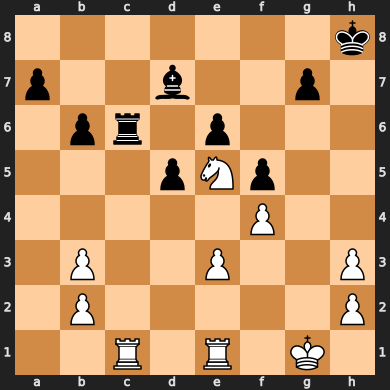

In [72]:
board

# Visualization

## Stockfish evaluation:

### NNUE:     +9.37

### Classical: +12.08

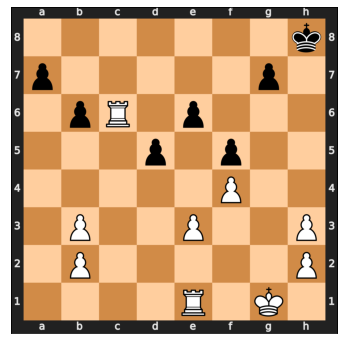

#### white has doubled pawns on files B and H

#### white has isolated pawns on files B and H

#### white has control of file(s) C

In [97]:
def eval_board(board, print_board = False, print_stockfish = False, print_concepts = False):
    
    results = get_nnue_eval_from_fen(board.fen())

    if print_stockfish:
        display(Markdown(f"## Stockfish evaluation:"))
        display(Markdown(f"### NNUE:     {results['eval']['NNUE']}"))
        display(Markdown(f"### Classical: {results['eval']['Classical']}"))
    if print_board:
        show_board(board)

    color_concepts = [get_doubled_pawns,
                    get_connected_rooks,
                    get_isolated_pawns,
                    has_control_of_open_file,
                    is_knight_forking,
                    ]

    global_concepts = [has_contested_open_file,
                        can_check]

    concept_results = []

    for concept in color_concepts:
        white_result = concept(board, color = 'white')
        black_result = concept(board, color = 'black')

        concept_results.append(white_result)
        concept_results.append(black_result)

        if print_concepts:
            if white_result['concept_activated'] == True:
                display(Markdown('#### '+ white_result['description']))
            if black_result['concept_activated'] == True:
                display(Markdown('#### '+ black_result['description']))


    for concept in global_concepts:
        result = concept(board)
        concept_results.append(result)

        if print_concepts:
            if result['concept_activated'] == True:
                display(Markdown('#### '+ result['description']))
    return {'concept_results': concept_results, 'stockfish_results': results['table'][['MG_total','EG_total']].to_dict()}

result = eval_board(board, print_board=True, print_stockfish=True, print_concepts=True)

In [98]:
result['concept_results']

[{'concept_activated': True,
  'description': 'white has doubled pawns on files B and H',
  'color': 'white',
  'concept_name': 'doubled_pawns'},
 {'concept_activated': False,
  'color': 'black',
  'concept_name': 'doubled_pawns'},
 {'concept_activated': False,
  'color': 'white',
  'concept_name': 'connected_rooks'},
 {'concept_activated': False,
  'color': 'black',
  'concept_name': 'connected_rooks'},
 {'concept_activated': True,
  'description': 'white has isolated pawns on files B and H',
  'color': 'white',
  'concept_name': 'isolated_pawns'},
 {'concept_activated': False,
  'color': 'black',
  'concept_name': 'isolated_pawns'},
 {'concept_activated': True,
  'description': 'white has control of file(s) C',
  'color': 'white',
  'concept_name': 'control_of_open_file'},
 {'concept_activated': False,
  'color': 'black',
  'concept_name': 'control_of_open_file'},
 {'concept_activated': False, 'color': 'white', 'concept_name': 'is_forking'},
 {'concept_activated': False, 'color': 'bl

In [24]:
from utils import stockfish_eval, get_config

config = get_config()
parameters = None
stockfish = stockfish_eval(path=config["STOCKFISH_PATH"], parameters=parameters)
stockfish.set_fen_position(fen)

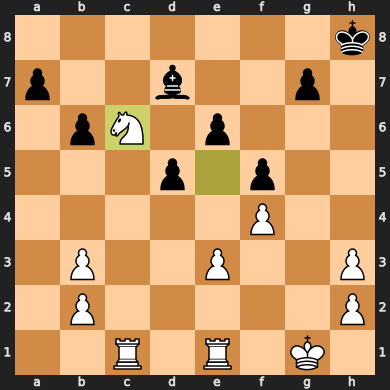

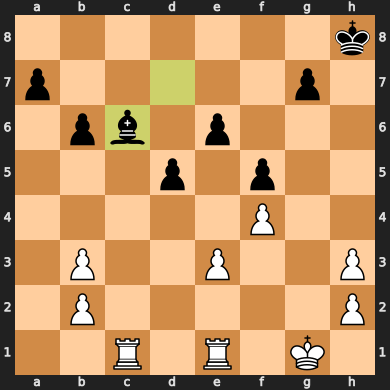

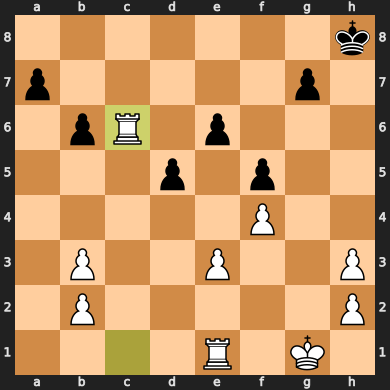

In [66]:
pv_results = []
pv_results.append(eval_board(board))
for i in range(3):
    stockfish.set_fen_position(board.fen())
    board.push(chess.Move.from_uci(stockfish.get_best_move()))
    pv_results.append(eval_board(board))
    display(board)
    

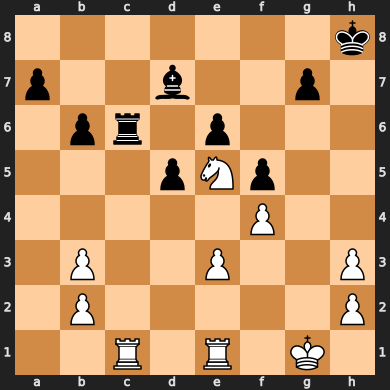

In [16]:
board

In [12]:
stockfish._is_ready()

In [9]:
stockfish.get_parameters()

{'Write Debug Log': 'false',
 'Contempt': 0,
 'Min Split Depth': 0,
 'Threads': 1,
 'Ponder': 'false',
 'Hash': 16,
 'MultiPV': 1,
 'Skill Level': 20,
 'Move Overhead': 30,
 'Minimum Thinking Time': 20,
 'Slow Mover': 80,
 'UCI_Chess960': 'false',
 'UCI_LimitStrength': 'false',
 'UCI_Elo': 1350,
 'UCI_ShowWDL': 'false'}

In [7]:
stockfish.set_fen_position(fen)

# Visualize concepts across time

In [105]:
board = chess.Board(fen)
pv_results = []
pv_results.append(eval_board(board))
for i in range(10):
    stockfish.set_fen_position(board.fen())
    board.push(chess.Move.from_uci(stockfish.get_best_move()))
    pv_results.append(eval_board(board))
    #display(board)

<AxesSubplot:>

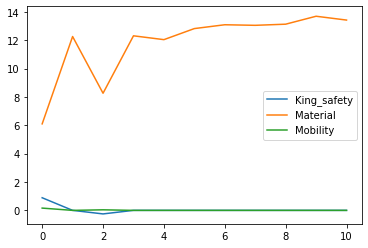

In [106]:
vis_stockfish_concepts = ['King_safety', 'Material', 'Mobility']
vis_custom_concepts = ['isolated_pawns','doubled_pawns','control_of_open_file']

vis = []

for pos_result in pv_results:
    pos_dict = {}
    for concept in vis_stockfish_concepts:
        pos_dict[concept] = pos_result['stockfish_results']['MG_total'][concept]

    #for concept in vis_custom_concepts:
    #    res = next(item for item in pos_result['concept_results'] if (item["concept_name"] == concept) & (item["color"] == "white"))
    #    pos_dict[concept] = res['concept_activated']

    vis.append(pos_dict)

pd.DataFrame(vis).astype(float).plot()

In [99]:
result['concept_results']

[{'concept_activated': True,
  'description': 'white has doubled pawns on files B and H',
  'color': 'white',
  'concept_name': 'doubled_pawns'},
 {'concept_activated': False,
  'color': 'black',
  'concept_name': 'doubled_pawns'},
 {'concept_activated': False,
  'color': 'white',
  'concept_name': 'connected_rooks'},
 {'concept_activated': False,
  'color': 'black',
  'concept_name': 'connected_rooks'},
 {'concept_activated': True,
  'description': 'white has isolated pawns on files B and H',
  'color': 'white',
  'concept_name': 'isolated_pawns'},
 {'concept_activated': False,
  'color': 'black',
  'concept_name': 'isolated_pawns'},
 {'concept_activated': True,
  'description': 'white has control of file(s) C',
  'color': 'white',
  'concept_name': 'control_of_open_file'},
 {'concept_activated': False,
  'color': 'black',
  'concept_name': 'control_of_open_file'},
 {'concept_activated': False, 'color': 'white', 'concept_name': 'is_forking'},
 {'concept_activated': False, 'color': 'bl